# Isolated Photon spectrum

## Introduction

The following images and slides are taken from the presentation that is referenced in the [overview](../index.md).
There, the few events that pass the _Higgsstrahlung-like_ event preselection can have interesting event shape distributions.

### Preselection

There are about 40k events that pass the preselection, out of 16 million.
We already saw in the [goodness of fit chapter](HiggsstrahlungRecoilGoodnessOfFit)
that the _Higgstrahlung-like_ events are in a tail of the `2f_Z_eehiq` distribution.

:::{warning}
These 40k events must not be confused with the 40k events in the MyLCTuple branch of the rootfile 
built from a single slcio-file.
With the preselection efficiency shown here, about 100 events per file would be expected to pass.

This number is reduced (much) further with the tighter final selection step in the Higgs branching ratios analysis.
:::

| | |
|:-:|:-:|
| ![isolated_photons_preselection_efficiency](../assets/isolated_photons_preselection_efficiency.png) | ![isolated_photons_count](../assets/isolated_photons_count.png) | 

### Isolated Photons

Isolated photons are defined by the [IsolatedPhotonTagging processor](https://github.com/iLCSoft/MarlinReco/tree/1538c295db82c620f6d62cd1db7f449aa31e5109/Analysis/IsolatedLeptonTagging).
We would expect that there can be high-energy photons in the 
$e^+e^- \to e^+e^-$ events with lepton-pair kinematics similar to Higgsstrahlung.
Indeed, in more than half the selected events we find an isolated photon in the detector volume
that is used in the study.

### "Higgs kinematics"

In a Higgsstrahlung event with leptonic decay of the recoiling Z boson, 
we want to identify the lepton pair from the Z decay.
If we correctly identify those decay remnants and remove them from the event,
we are left with only the decay products from the Higgs decay (plus contributions from overlay).
Therefore the mass and energy of the sum of all these remaining PFOs will be called _Higgs mass_ and _Higgs energy_.

These onedimensional distributions show an interesting shape:

| | |
|:-:|:-:|
| ![higgs_mass_all](../assets/isolated_photons_higgs_mass_all.png) | ![higgs_energy_all](../assets/isolated_photons_higgs_energy_all.png)  |

As a first estimate, we could assume that both distributions are Dirac-$\delta$-distributions at 0 GeV:
There is no Higgs boson in the `2f_Z_eehiq` events.

The convolution with beam overlay will smear this to an exponentially decaying distribution.

On top of this, we observe a peak at around 140 GeV in the mass spectrum and multiple peaks in the energy spectrum.

These additional features can be identified as the effect of high-energy photons in the detector.
_You can enlarge the following slides by opening them in a new tab._

|Mass in the event after removing the $e^+e^-$ pair  | Energy in the event after removing the $e^+e^-$ pair  | 
|:-:|:-:|
| ![higgs_mass](../assets/isolated_photons_higgs_mass.png) | ![higgs_energy](../assets/isolated_photons_higgs_energy.png)  |

## "Higgs kinematics" without preselection

### On PandoraPFOs level

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lcio_checks.rp.split_off_z import HiggsLike
from lcio_checks.util import config


def plot_masses(m_pair, m_recoil, bins=20, bin_range=[[0, 300], [0, 300]], ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist2d(m_pair, m_recoil, range=bin_range, bins=bins)
    ax.set_xlabel("pair mass [GeV]")
    ax.set_ylabel("recoil mass [GeV]")
    return ax


def chi2_fct(z, h):
    return (z - 91) ** 2 / 10**2 + (h - 125) ** 2 / (
        5**2 * (h < 125) + 20**2 * (h > 125)
    )


f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
rc = f.arrays(filter_name="rc*")
rc = rc[rc.rccid == 101]

higgs_like = HiggsLike(rc)
has_pair = higgs_like.has_pair
higgs_like.apply_chi2(chi2_fct)

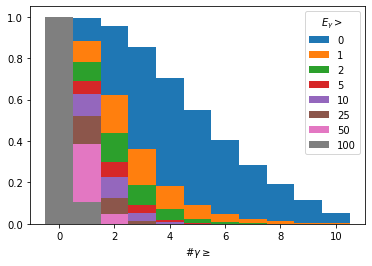

In [2]:
bins = np.arange(-0.5, 11)
e_gamma = rc[rc.rctyp == 22].rcene
for min_e in [0, 1, 2, 5, 10, 25, 50, 100]:
    plt.hist(
        ak.num(e_gamma[e_gamma > min_e], axis=1),
        bins,
        cumulative=-1,
        density=True,
        label=min_e,
    )
plt.legend(title=r"$E_\gamma >$")
plt.xlabel(r"#$\gamma \geq$");

For some simple plotting in this motebook, let's define as an _Isolated Photon_ any PFO that is identified as a photon and that has an energy above 25 GeV.

In [3]:
def m_vis(rps):
    e = ak.sum(rps.rcene, axis=1)
    px = ak.sum(rps.rcmox, axis=1)
    py = ak.sum(rps.rcmoy, axis=1)
    pz = ak.sum(rps.rcmoz, axis=1)
    return np.sqrt(np.abs(e**2 - px**2 - py**2 - pz**2))


def mass_plot(rps, gamma_rps=None, sub="_H"):
    if gamma_rps is None:
        gamma_rps = rps
    e_gamma = gamma_rps.rcene[gamma_rps.rctyp == 22]
    n_gamma = ak.num(e_gamma[e_gamma > 25])
    n_gamma = ak.where(n_gamma < 3, n_gamma, 3)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    for i in range(3):
        mask = n_gamma >= i
        if sum(mask) == 0:
            continue
        axs[0].hist(m_vis(rps[mask]), bins=30, label=f"# Isolated photons >= {i}")
        axs[1].hist(m_vis(rps[mask]), bins=30)
    axs[0].legend()
    axs[1].set_yscale("log")
    axs[0].set_xlabel(f"$M{sub}$")
    axs[1].set_xlabel(f"$M{sub}$")
    return axs


def energy_plot(rps, gamma_rps=None, sub="_H"):
    if gamma_rps is None:
        gamma_rps = rps
    e_gamma = gamma_rps.rcene[gamma_rps.rctyp == 22]
    n_gamma = ak.num(e_gamma[e_gamma > 25])
    n_gamma = ak.where(n_gamma < 3, n_gamma, 3)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    for i in range(3):
        mask = n_gamma >= i
        if sum(mask) == 0:
            continue
        axs[0].hist(m_vis(rps[mask]), bins=30, label=f"# Isolated photons >= {i}")
        axs[1].hist(m_vis(rps[mask]), bins=30)
    axs[0].legend()
    axs[1].set_yscale("log")
    axs[0].set_xlabel(f"$E{sub}$")
    axs[1].set_xlabel(f"$E{sub}$")
    return axs

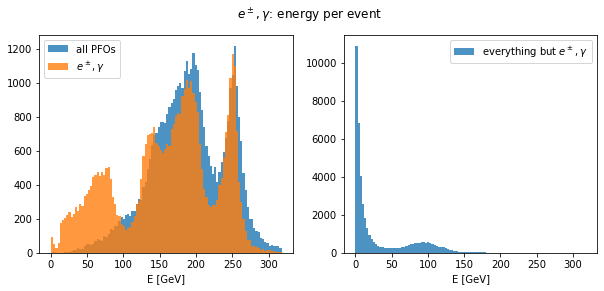

In [4]:
bins = np.arange(0, 321, 3)
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
is_e_gamma = (rc.rctyp == 11) | (rc.rctyp == -11) | (rc.rctyp == 22)
axs[0].hist(ak.sum(rc.rcene, axis=1), bins=bins, alpha=0.8, label="all PFOs")
axs[0].hist(
    ak.sum(rc.rcene[is_e_gamma], axis=1), bins=bins, alpha=0.8, label=r"$e^\pm, \gamma$"
)
axs[1].hist(
    ak.sum(rc.rcene[~is_e_gamma], axis=1),
    bins=bins,
    alpha=0.8,
    label=r"everything but $e^\pm, \gamma$",
)
for ax in axs:
    ax.legend()
    ax.set_xlabel("E [GeV]")
fig.suptitle(r"$e^\pm, \gamma$: energy per event");

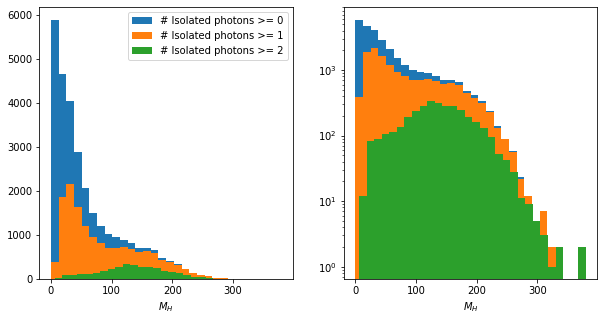

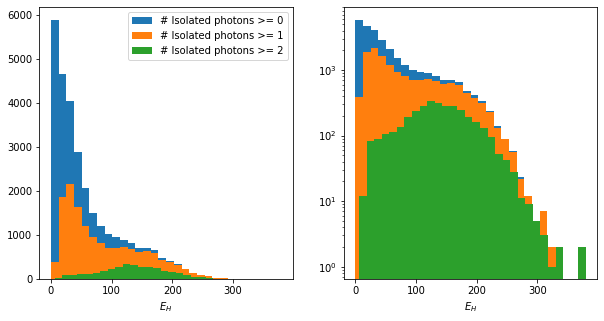

In [5]:
rps = rc[higgs_like.has_pair]
rps = rps[~rps.is_recoil]
mass_plot(rps)
energy_plot(rps);

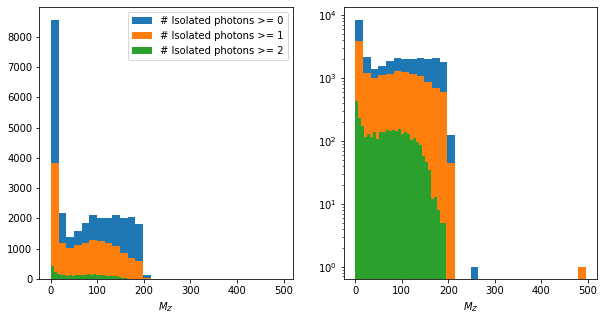

In [6]:
rps = rc[higgs_like.has_pair]

mass_plot(rps[rps.is_recoil], rps, sub="_Z");

## Choose only event with kinematics close to Higgsstrahlung

$\chi^2$ takes into account the mass of the recoiling electron pair and the recoil mass.

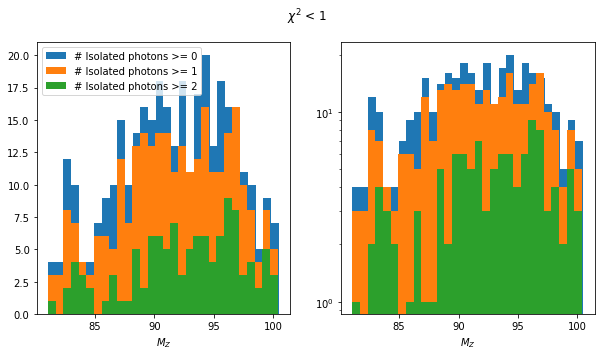

In [7]:
max_chi2 = 1
rps = rc[ak.fill_none(ak.min(higgs_like.chi2, axis=1) < max_chi2, False)]

mass_plot(rps[rps.is_recoil], rps, sub="_Z")
plt.suptitle(rf"$\chi^2$ < {max_chi2}");

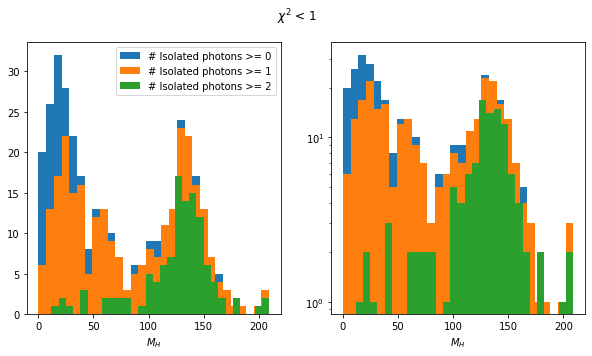

In [8]:
max_chi2 = 1
rps = rc[ak.fill_none(ak.min(higgs_like.chi2, axis=1) < max_chi2, False)]
rps = rps[~rps.is_recoil]
mass_plot(rps)
plt.suptitle(rf"$\chi^2$ < {max_chi2}");

![higgs_mass](../assets/isolated_photons_higgs_mass.png)

Clearly, the two definitions of _Isolated Photon_ are not very compatible.
This is to be expected: The definition in this notebook is very simplistic.
Both spectra find the peak around 140 GeV. 
The peak is more important in the notebook.
By loosening the $\chi^2$ selection (see appendix), more low-recoil-mass events pass the selection
and we approach the situation shown in the presentation.


## TODO

- [ ] FSR photon correction?
- [ ] The spectrum in the presentation peaks at 0 GeV. Here, the low-mass peak is around 20 GeV. Might be the FSR though.

## Appendix: Playing with the selection tightness

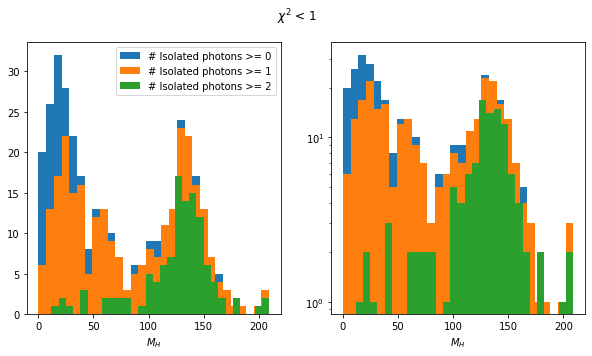

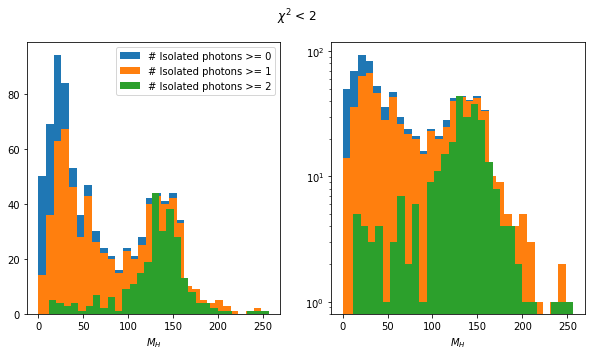

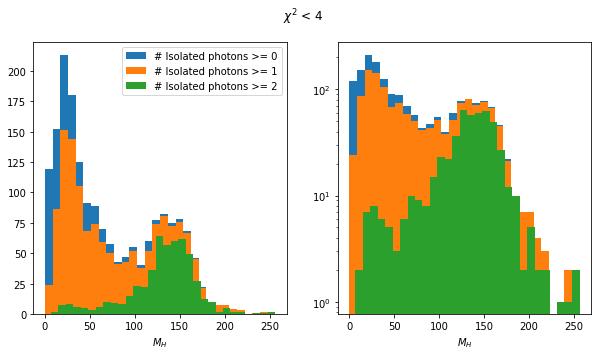

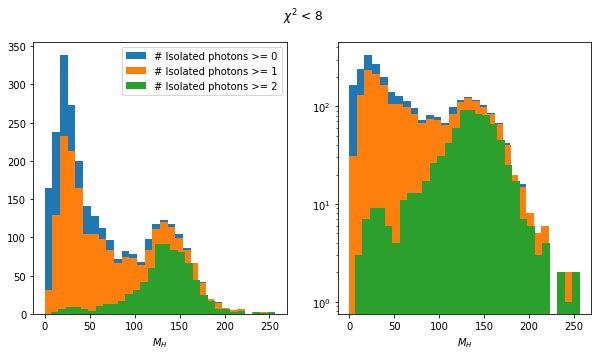

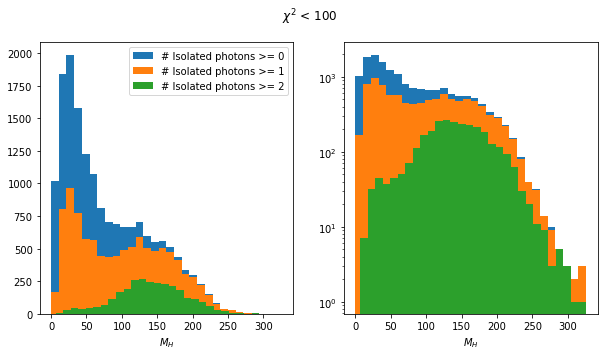

In [9]:
for max_chi2 in [1, 2, 4, 8, 100]:
    rps = rc[ak.fill_none(ak.min(higgs_like.chi2, axis=1) < max_chi2, False)]
    rps = rps[~rps.is_recoil]
    mass_plot(rps)
    plt.suptitle(rf"$\chi^2$ < {max_chi2}");